<a href="https://colab.research.google.com/github/Kamruzzaman2200/Datamining/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install required packages

In [1]:
!pip install ucimlrepo pandas numpy scikit-learn matplotlib seaborn joblib xgboost lightgbm --quiet

#Configuration & imports

In [2]:
RANDOM_STATE = 42
RESULTS_DIR = "/mnt/data/diabetic_models_results"
DATA_SAVE_PATH = "/mnt/data/diabetic_data_uci.csv"
import os
os.makedirs(RESULTS_DIR, exist_ok=True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib


#Fetch dataset from UCI repo

In [3]:
print("Fetching dataset id=296 (Diabetes 130-US hospitals for years 1999-2008)...")
diabetes_uci = fetch_ucirepo(id=296)

X = diabetes_uci.data.features
y = diabetes_uci.data.targets
if isinstance(y, pd.DataFrame) and y.shape[1] == 1:
    y = y.iloc[:, 0]

df = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
print("Dataset loaded:", df.shape)
print("Columns sample:", df.columns.tolist()[:30])


Fetching dataset id=296 (Diabetes 130-US hospitals for years 1999-2008)...


/usr/local/lib/python3.12/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


Dataset loaded: (101766, 48)
Columns sample: ['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide']


#Identify target ('readmitted') and show distribution

In [4]:
if 'readmitted' in df.columns:
    TARGET = 'readmitted'
else:
    # fallback heuristic
    possible = [c for c in df.columns if c.lower().find('read')!=-1 or c.lower().find('admit')!=-1]
    TARGET = possible[0] if possible else None

if TARGET is None:
    raise ValueError("Target column not found automatically. Inspect df.columns and set TARGET manually.")
print("TARGET =", TARGET)
display(df[TARGET].value_counts())


TARGET = readmitted


,count
readmitted,
NO,54864
>30,35545
<30,11357


#Basic cleaning

In [5]:
# Replace UCI '?' unknown tokens with NaN
df = df.replace('?', np.nan)

# Drop identifier columns if present
drop_cols = [c for c in ['encounter_id', 'patient_nbr'] if c in df.columns]
if drop_cols:
    print("Dropping identifiers:", drop_cols)
    df = df.drop(columns=drop_cols)

# Save a local copy
df.to_csv(DATA_SAVE_PATH, index=False)
print("Saved local copy to:", DATA_SAVE_PATH)

# Show missing value summary
missing = df.isnull().sum().sort_values(ascending=False)
display(missing[missing>0].head(50))


Saved local copy to: /mnt/data/diabetic_data_uci.csv


,0
weight,98569
max_glu_serum,96420
A1Cresult,84748
medical_specialty,49949
payer_code,40256
race,2273
diag_3,1423
diag_2,358
diag_1,21


#Split numeric and categorical columns

In [6]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
if TARGET in categorical_cols:
    categorical_cols.remove(TARGET)

print("Numeric cols:", len(numeric_cols), "Categorical cols:", len(categorical_cols))
print("Example numeric:", numeric_cols[:10])
print("Example categorical:", categorical_cols[:20])


Numeric cols: 11 Categorical cols: 36
Example numeric: ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient']
Example categorical: ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide']


#Quick EDA: target distribution & example cross-tab

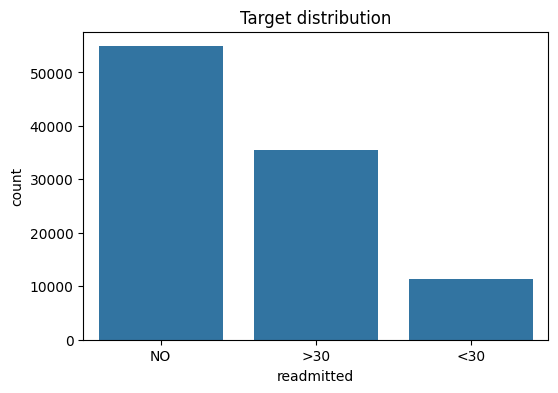

readmitted,<30,>30,NO
age,,,
[0-10),0.018634,0.161491,0.819876
[10-20),0.057887,0.324168,0.617945
[20-30),0.142426,0.307785,0.549789
[30-40),0.112318,0.314437,0.573245
[40-50),0.106040,0.338462,0.555498
[50-60),0.096662,0.342895,0.560443
[60-70),0.111284,0.351243,0.537473
[70-80),0.117731,0.363472,0.518797
[80-90),0.120835,0.361865,0.517300


In [7]:

plt.figure(figsize=(6,4))
sns.countplot(x=TARGET, data=df, order=df[TARGET].value_counts().index)
plt.title("Target distribution")
plt.show()

if 'age' in df.columns:
    display(pd.crosstab(df['age'], df[TARGET], normalize='index').head(12))


#Preprocessing pipelines (fit only on training data to avoid leakage)

In [8]:
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Keep sparse_output=False for simplicity; if memory becomes issue set sparse_output=True and adapt code
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_cols),
        ('cat', cat_transformer, categorical_cols)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

#Train/test split

In [9]:
X = df.drop(columns=[TARGET])
y = df[TARGET].copy()

# Stratify on original multi-class target (NO, >30, <30)
print("Target classes:", y.unique())
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
print("Train/Test shapes:", X_train.shape, X_test.shape)


Target classes: ['NO' '>30' '<30']
Train/Test shapes: (81412, 47) (20354, 47)


#Define classifiers to evaluate

In [10]:
# Note: GaussianNB requires dense input; we will handle that by wrapping pipeline appropriately.
from sklearn.base import clone

classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=400, random_state=RANDOM_STATE, solver='saga', multi_class='multinomial'),
    "RandomForest": RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
    "LinearSVC": LinearSVC(max_iter=2000, random_state=RANDOM_STATE),
    "KNeighbors": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "GaussianNB": GaussianNB()
}

# Try to include XGBoost and LightGBM if available
try:
    from xgboost import XGBClassifier
    classifiers["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE, n_jobs=-1)
except Exception as e:
    print("xgboost not available:", e)

try:
    from lightgbm import LGBMClassifier
    classifiers["LightGBM"] = LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1)
except Exception as e:
    print("lightgbm not available:", e)

print("Classifiers to run:", list(classifiers.keys()))


Classifiers to run: ['LogisticRegression', 'RandomForest', 'LinearSVC', 'KNeighbors', 'GaussianNB', 'XGBoost', 'LightGBM']


#Train & evaluate each classifier (cross-val on training set + test eval)

In [ ]:

results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, clf in classifiers.items():
    print("\n==========", name, "==========")
    # Build a pipeline: preprocessor then classifier
    # For GaussianNB we must ensure dense array (OneHotEncoder sparse=False above ensures dense)
    pipe = Pipeline([
        ('preproc', preprocessor),
        ('clf', clf)
    ])
    # cross-val on training set
    try:
        cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
        cv_mean, cv_std = float(cv_scores.mean()), float(cv_scores.std())
        print(f"{name} CV accuracy: {cv_mean:.4f} ± {cv_std:.4f}")
    except Exception as e:
        print("Cross-val failed for", name, ":", e)
        cv_mean, cv_std = np.nan, np.nan

    # Fit on full training set and evaluate on test set
    try:
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        test_acc = accuracy_score(y_test, y_pred)
        print(f"{name} Test accuracy: {test_acc:.4f}")
        print("Classification report:")
        print(classification_report(y_test, y_pred))
        # Save fitted pipeline
        joblib.dump(pipe, os.path.join(RESULTS_DIR, f"pipeline_{name}.joblib"))
    except Exception as e:
        print("Training/eval failed for", name, ":", e)
        test_acc = np.nan

    results.append({
        "model": name,
        "cv_mean_accuracy": cv_mean,
        "cv_std_accuracy": cv_std,
        "test_accuracy": test_acc
    })

# Summary DataFrame
results_df = pd.DataFrame(results).sort_values(by='test_accuracy', ascending=False)
results_df.to_csv(os.path.join(RESULTS_DIR, "models_comparison.csv"), index=False)
print("\nAll results saved to:", RESULTS_DIR)
display(results_df)



========== LogisticRegression ==========


#Confusion matrix of the best model (by test accuracy)

In [ ]:
best_model_name = results_df.iloc[0]['model']
print("Best model:", best_model_name)
best_pipe = joblib.load(os.path.join(RESULTS_DIR, f"pipeline_{best_model_name}.joblib"))
y_pred_best = best_pipe.predict(X_test)

labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_best, labels=labels)
fig, ax = plt.subplots(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, f"confusion_matrix_{best_model_name}.png"))
plt.show()

#Convert to binary target (<30 vs else) and re-run quick comparison

In [ ]:

print("Binary target: '<30' -> 1, else -> 0")
binary_y = (df[TARGET] == "<30").astype(int)
X_b = df.drop(columns=[TARGET])
y_b = binary_y

Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_b, y_b, test_size=0.20, stratify=y_b, random_state=RANDOM_STATE)

binary_results = []
for name, clf in classifiers.items():
    pipe = Pipeline([('preproc', preprocessor), ('clf', clone(clf))])
    try:
        pipe.fit(Xb_train, yb_train)
        yb_pred = pipe.predict(Xb_test)
        acc = accuracy_score(yb_test, yb_pred)
        print(f"{name} (binary) accuracy: {acc:.4f}")
        binary_results.append({"model":name, "binary_test_accuracy":acc})
        joblib.dump(pipe, os.path.join(RESULTS_DIR, f"pipeline_{name}_binary.joblib"))
    except Exception as e:
        print("Binary run failed for", name, ":", e)
        binary_results.append({"model":name, "binary_test_accuracy":np.nan})

pd.DataFrame(binary_results).to_csv(os.path.join(RESULTS_DIR, "models_binary_comparison.csv"), index=False)


#Wrap-up: list saved files and give quick guidance

In [ ]:

print("Finished. Files saved in:", RESULTS_DIR)
for fname in sorted(os.listdir(RESULTS_DIR)):
    print(" -", fname)

print("""
Notes:
 - OneHotEncoder(sparse=False) is used here for clarity. If you run into memory issues, set sparse=True and adapt downstream or reduce cardinality for categorical features.
 - XGBoost / LightGBM are optional. If they were not available at install time they won't appear in the classifiers list.
 - Use StratifiedKFold for consistent CV on imbalanced targets.
 - For production, consider hyperparameter tuning (GridSearchCV) per model and more advanced encodings (target encoding) for high-cardinality features.
""")
